In [88]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

In [87]:
%whos

Variable                Type                          Data/Info
---------------------------------------------------------------
Image                   type                          <class 'IPython.core.display.Image'>
coffee_shop             type                          <class '__main__.coffee_shop'>
default_rng             builtin_function_or_method    <built-in function default_rng>
get_average_wait_time   function                      <function get_average_wai<...>t_time at 0x7fefb954ecb0>
get_coffee              function                      <function get_coffee at 0x7fefb954e8c0>
get_max_wait_time       function                      <function get_max_wait_time at 0x7fefb9537b90>
get_user_input          function                      <function get_user_input at 0x7fefb954edd0>
i                       float64                       0.8549888381475644
main                    function                      <function main at 0x7fefb954ea70>
math                    module                

In [4]:
import random

In [5]:
from numpy.random import default_rng
rg = default_rng(seed=4470)

In [ ]:
rg.

In [6]:
import statistics

In [7]:
wait_times = []
timestamps_list = []

In [66]:
class coffee_shop(object):
    def __init__(self, env, num_cashiers = 2, num_baristas = 2, mean_order_time = .4, sd_order_time = .05, mean_fulfillment_time = .75, sd_fulfillment_time = .10, rg = rg):
        
        self.env = env
        self.rg = rg
        
        self.cashiers = simpy.Resource(env, num_cashiers)
        self.baristas = simpy.Resource(env, num_baristas)
        
        self.mean_order_time = mean_order_time
        self.sd_order_time = sd_order_time
        
        self.mean_fulfillment_time = mean_fulfillment_time
        self.sd_fulfillment_time = sd_fulfillment_time
        
    def order_drinks(self, customer):
        yield self.env.timeout(self.rg.normal(self.mean_order_time, self.sd_order_time))
        
    def get_drinks(self, customer):
        yield self.env.timeout(self.rg.normal(self.mean_fulfillment_time, self.sd_fulfillment_time))

In [100]:
s = np.random.poisson(1, 10000) + 1

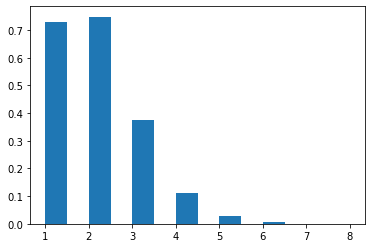

In [101]:
count, bins, ignored = plt.hist(s, 14, density=True)
plt.show()

In [93]:
s[:10]

array([0, 2, 1, 1, 1, 3, 3, 3, 3, 0])

In [64]:
q = rg.normal(.75, .1, 100000111)

In [65]:
for i in q:
    if i < 0:
        print(i)

-0.0022236960006020157
-0.03267066261642859
-0.04065788846497875
-0.0022462260602068573
-0.04642395790129539
-0.024043787464899435
-0.025934816720532106
-0.024688514685128782
-0.059432118806894585
-0.006561442305560106
-0.020615052689159086
-0.0093544304992762
-0.03205367291350503
-0.024792872578372704
-0.057309854463723275
-0.022394247539192724
-0.008089370779888694
-0.07482678045249602
-0.003654583320604199
-0.0037652741971941905
-0.014324328687605914
-0.01557822808321252
-0.04770198415643179
-0.014433682614635401
-0.09516397521791531
-0.002197449549930619
-0.07238053143149337
-0.033590830976264585
-0.0560437989058481
-0.004579693632940973
-0.01716713641608336
-0.02477322262272652
-0.04389623318075431
-0.007351252034039302


In [116]:
def get_coffee(env, customer, Coffee_shop):
    arrival_time = env.now
    order_qty = rg.poisson(1) + 1
    
    with Coffee_shop.cashiers.request() as request:
        yield request
        reached_cashier = env.now
        for i in range(order_qty):
            yield env.process(Coffee_shop.order_drinks(customer))
            # print(f"Customer {customer + 1} order for item {i + 1} of {order_qty} is placed at time {env.now:.2f}")
    order_placed = env.now
    
    with Coffee_shop.baristas.request() as request:
        yield request
        reached_barista = env.now
        for i in range(order_qty):
            yield env.process(Coffee_shop.get_drinks(customer))
            # print(f"Customer {customer + 1} order for item {i + 1} of {order_qty} is fulfilled at time {env.now:.2f}")
    order_fulfilled = env.now
    
    total_drinks.append(order_qty + 1)
    wait_times.append(env.now - arrival_time)
    wait_time = env.now - arrival_time
    order_to_fulfillment_wait = order_fulfilled - order_placed
    
    timestamps = {'customer_id': customer + 1,
                  'arrival_time': arrival_time,
                  'reached_cashier': reached_cashier,
                  'order_qty': order_qty,
                  'order_placed': order_placed,
                  'reached_barista': reached_barista,
                  'order_fulfilled': order_fulfilled,
                  'order_processing_time': order_to_fulfillment_wait,
                  'total_wait': wait_time}
    
    timestamps_list.append(timestamps)
    

In [103]:
def run_coffee_shop(env, num_cashiers, num_baristas, stoptime = simpy.core.Infinity, max_arrivals = 200):
    Coffee_shop = coffee_shop(env, num_cashiers, num_baristas)
    
    for customer in range(3):
        env.process(get_coffee(env, customer, Coffee_shop))
    
    while env.now < stoptime and customer < max_arrivals:
        iat = rg.poisson(1)
        
        yield env.timeout(iat)
        
        customer += 1
        
        env.process(get_coffee(env, customer, Coffee_shop))
        
    print(f"{customer} customers have arrived.")
    
    

In [104]:
def get_user_input():
    num_cashiers = input("Input # of cashiers working: ")
    num_baristas = input("Input # of baristas working: ")
    params = [num_cashiers, num_baristas]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Could not parse input. The simulation will use default values:",
            "\n1 cashier, 1 baristas.",
        )
        params = [1, 1]
    return params

In [105]:
def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [106]:
def get_max_wait_time(wait_times):
    max_wait = np.max(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(max_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [117]:
total_drinks = []
wait_times = []
timestamps_list = []
def main():
    # Setup
    random.seed(42)
    num_cashiers, num_baristas = get_user_input()
    
    print("Running simulation...")

    # Run the simulation
    env = simpy.Environment()
    env.process(run_coffee_shop(env, num_cashiers, num_baristas, stoptime = simpy.core.Infinity, max_arrivals = 400))
    env.run()

    # View the results
    tot_drinks = sum(total_drinks)
    mins, secs = get_average_wait_time(wait_times)
    mx_mins, mx_secs = get_max_wait_time(wait_times)
    print(
        f"\nCoffee shop made {tot_drinks} drinks.",
        f"\nThe average wait time is {mins} minutes and {secs} seconds.",
        f"\nThe longest wait time was {mx_mins} minutes and {mx_secs} seconds.",
    )


if __name__ == "__main__":
    main()

Input # of cashiers working:  1
Input # of baristas working:  2


Running simulation...
400 customers have arrived.

Coffee shop made 1201 drinks. 
The average wait time is 3 minutes and 35 seconds. 
The longest wait time was 11 minutes and 19 seconds.


In [61]:
a = [1,2,3,4,5]

In [63]:
sum(a)

15

In [114]:
df = pd.DataFrame(timestamps_list)

In [115]:
df.head()

,customer_id,arrival_time,reached_cashier,order_qty,order_placed,reached_barista,order_fulfilled,order_processing_time,total_wait
0,2,0,0.368416,1,0.556934,0.556934,1.394976,0.838042,1.394976
1,1,0,0.000000,2,0.368416,0.368416,1.719692,1.351276,1.719692
2,3,0,0.556934,1,0.743947,1.394976,2.219421,1.475473,2.219421
3,4,0,0.743947,2,1.197927,1.719692,3.474621,2.276694,3.474621
4,5,1,1.197927,3,1.818438,2.219421,4.493813,2.675375,3.493813
